## Setup

In [2]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.stats import norm, linregress
from scipy.optimize import curve_fit
from uncertainties import ufloat
from scipy.signal import find_peaks

No module named 'rtlsdr'


In [3]:
# Consistent Plot Params
titleSize = 15
axisSize = 15
legendSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)

## Data Extraction

In [4]:
def extractRawData(folder, filename):
    prefix = "ugastro\\Lab3Data\\" + folder
    raw_data = np.load(prefix + filename, allow_pickle=True)
    return raw_data

def getDataBlocks(data, buffer=10, num_blocks=2030):
    new_data = np.zeros((num_blocks, 1024), dtype=complex)
    for i, block in enumerate(data[buffer:num_blocks+buffer]):
        new_data[i] = normalize(block['corr01'])
    return new_data

def getDataSingleBlock(data, block=1):
    real = data['time_data'][block][:, 0]
    imag = data['time_data'][block][:, 1]
    return normalize(real + (1j * imag))

def getSampleRate(data):
    return data['sample_rate']

def getGain(data):
    return data['gain']

def getUTC(data):
    return data['utc']

def getJulianDate(data):
    return data['jd']

def windowData(data):
    return data[:]

def normalize(data):
    return (data - np.mean(data)) #/ np.std(data)

def getTimes(N, sample_rate=3.1e6):
    return [i / sample_rate for i in range(0, N)]

In [5]:
# Week 1
folder = "Week1_Testing\\"
data_test_raw = extractRawData(folder, "test_observatin_data.npy")
data_test = getDataBlocks(data_test_raw)
data_test_2_raw = extractRawData(folder, "Mar12_test_observation_data.npz")
data_test_2 = getDataBlocks(data_test_2_raw['arr_0'])

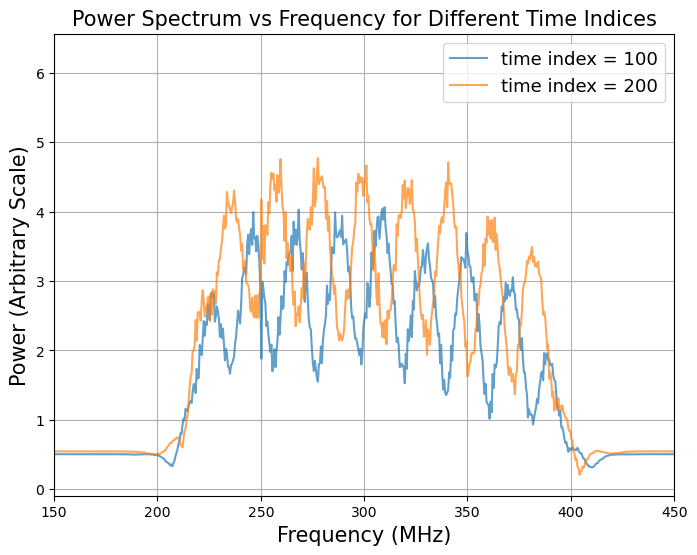

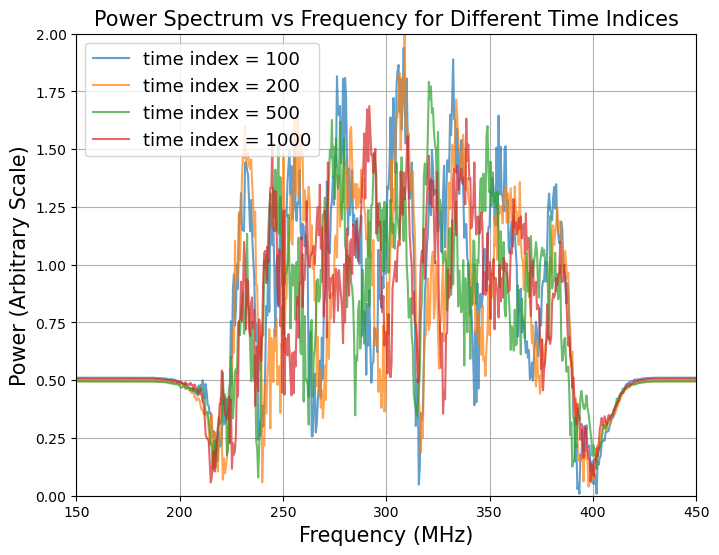

In [6]:
def plot_power_spectrum(data, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    freqs = np.linspace(0, 500, len(data[0]))

    for index in indices:
        spectrum = np.abs(data[index])
        plt.plot(freqs, spectrum, label=f"time index = {index}", alpha=0.7)
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Power (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Power Spectrum vs Frequency for Different Time Indices", size=titleSize)
    plt.grid()
    plt.show()

plot_power_spectrum(data_test, indices=[100, 200], xlim=(150, 450))
plot_power_spectrum(data_test_2, indices=[100, 200, 500, 1000], xlim=(150, 450), ylim=(0, 2))

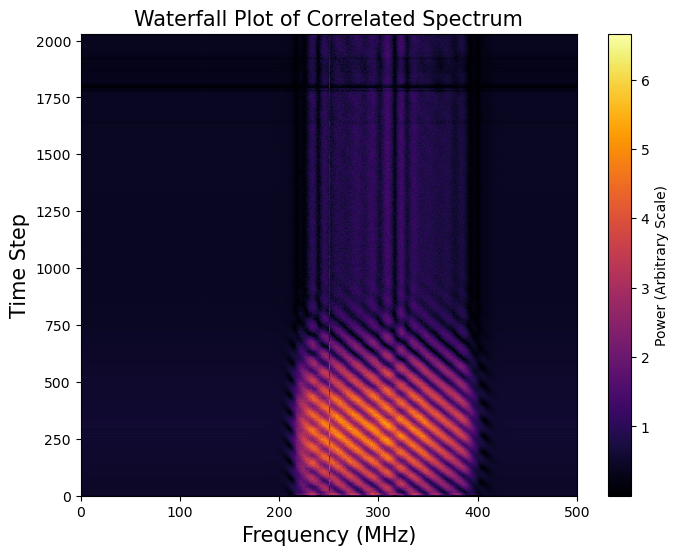

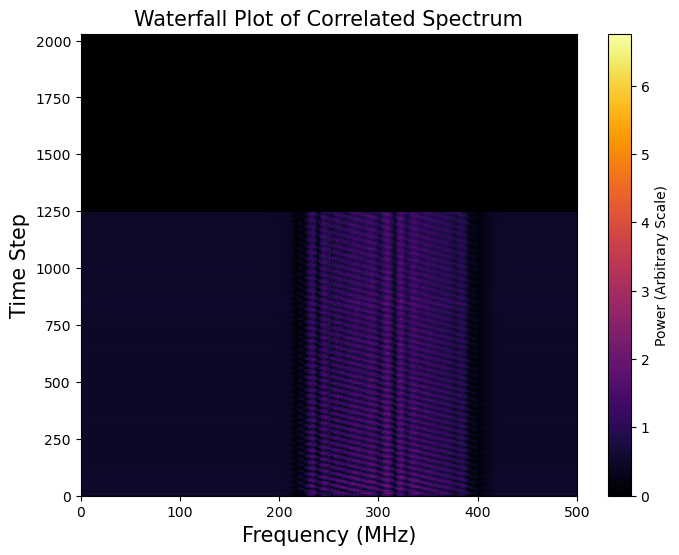

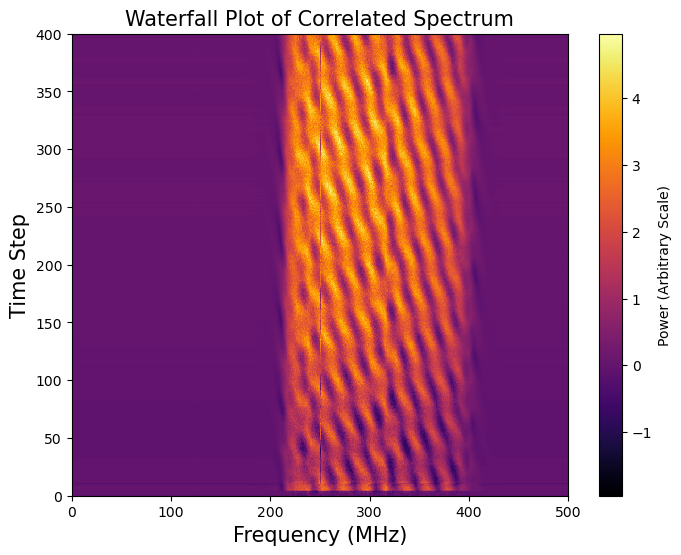

In [ ]:
def plot_waterfall(data):
    plt.figure(figsize=graphSizeSingle)
    plt.imshow(np.abs(data), aspect='auto', cmap='inferno', norm='linear',
               extent=[0, 500, 0, data.shape[0]], interpolation='nearest',
               origin='lower')
    plt.colorbar(label="Power (Arbitrary Scale)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.title("Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()

def plot_waterfall_corr(data, baseline):
    plt.figure(figsize=graphSizeSingle)
    plt.imshow(np.abs(data) - np.abs(baseline), aspect='auto', cmap='inferno', norm='linear',
               extent=[0, 500, 0, data.shape[0]], interpolation='nearest',
               origin='lower')
    plt.colorbar(label="Power (Arbitrary Scale)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.title("Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()

#plot_waterfall(data_test)
#plot_waterfall(data_test_2)
plot_waterfall_corr(data_test[:400], data_test_2[:400])

In [9]:
print("First time step max power:", np.max(np.abs(data_test[0])))
print("Middle time step max power:", np.max(np.abs(data_test[1000])))
print("Last time step max power:", np.max(np.abs(data_test[2000])))

First time step max power: 6.479164848331056
Middle time step max power: 5.474793418763554
Last time step max power: 6.287294479134265


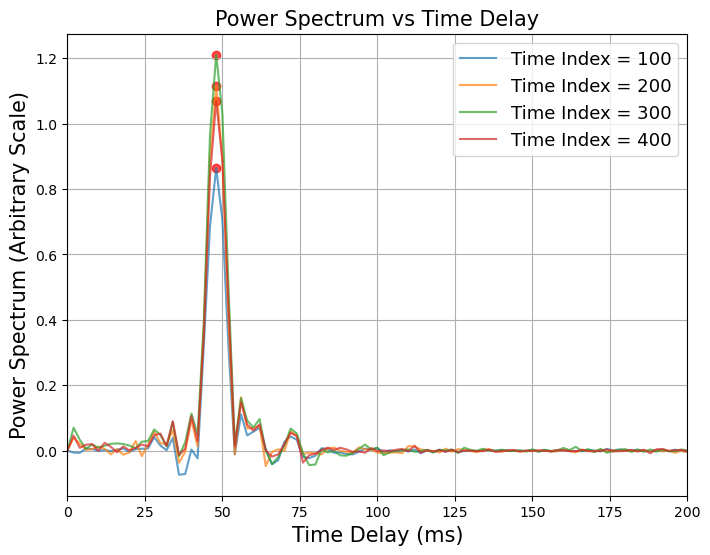

Peaks = 24
Amplitudes = 1.07


In [34]:
def plot_time_delay(data, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [2*i for i in range(len(data[0]))] # 2ms per sample

    for index in indices:
        time_signal = np.abs(ifft(data[index]))
        amplitude = np.abs(time_signal)
        threshold = 0.2 * np.max(amplitude)
        peaks, properties = find_peaks(amplitude, height=threshold)
        if index == 0:
            print(f"Peak = {peaks}")

        plt.plot(times, amplitude, label=f"Time Index = {index}", alpha=0.7)
        plt.scatter(peaks*2, amplitude[peaks], color='r', marker='o', alpha=0.7)
    plt.xlabel("Time Delay (ms)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Power Spectrum vs Time Delay", size=titleSize)
    plt.grid()
    plt.show()
    return peaks, properties

def plot_time_delay_corr(data, baseline, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [2*i for i in range(len(data[0]))] # 2ms per sample

    for index in indices:
        time_signal = np.abs(ifft(data[index]))
        time_signal_baseline = np.abs(ifft(baseline[index]))
        amplitude = np.abs(time_signal)
        amplitude_baseline = np.abs(time_signal_baseline)
        amplitude -= amplitude_baseline
        threshold = 0.2 * np.max(amplitude)
        peaks, properties = find_peaks(amplitude, height=threshold)

        plt.plot(times, amplitude, label=f"Time Index = {index}", alpha=0.7)
        plt.scatter(peaks*2, amplitude[peaks], color='r', marker='o', alpha=0.7)
    plt.xlabel("Time Delay (ms)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Power Spectrum vs Time Delay", size=titleSize)
    plt.grid()
    plt.show()
    return peaks, properties

#plot_time_delay(data_test, indices=[100, 200, 300, 400, 500], xlim=(0, 200))
#plot_time_delay(data_test_2, indices=[100, 200, 300, 400, 500], xlim=(0, 200))
peaks, amps = plot_time_delay_corr(data_test[:450], data_test_2[:450], indices=[100, 200, 300, 400], xlim=(0, 200))
print(f"Peaks = {peaks[0]}")
print(f"Amplitudes = {np.round(amps['peak_heights'][0], 3)}")

look into np.angle

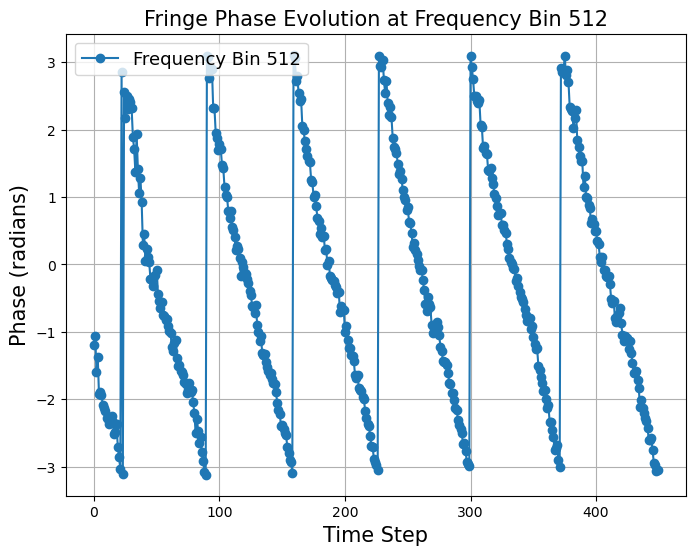

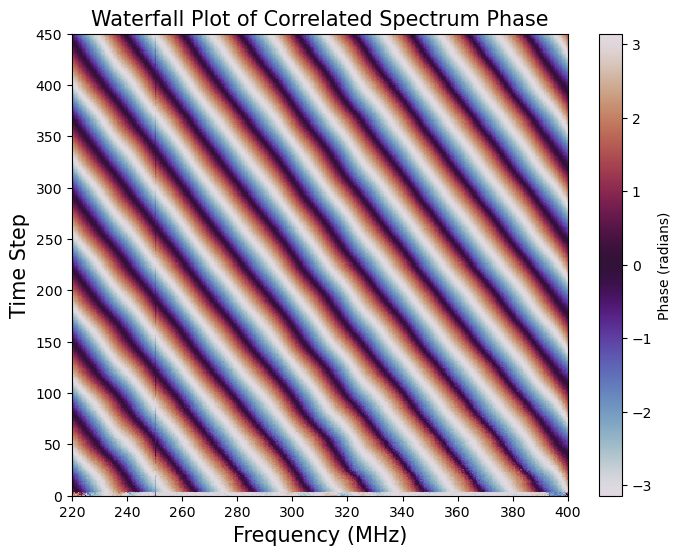

In [ ]:
def plot_phase_evolution(data, freq_bin=512):
    time_steps = np.arange(data.shape[0])
    phases = np.angle(data[:, freq_bin])  # Extract column (frequency bin) and compute phase

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, phases, marker='o', linestyle='-', label=f"Frequency Bin {freq_bin}")
    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Phase (radians)", fontsize=axisSize)
    plt.title(f"Fringe Phase Evolution at Frequency Bin {freq_bin}", size=titleSize)
    plt.legend(fontsize=legendSize)
    plt.grid()
    plt.show()

def plot_phase_waterfall(data, freq_bin=512, xlim=None, ylim=None):
    phases = np.angle(data)

    plt.figure(figsize=graphSizeSingle)
    plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear',
               extent=[0, 500, 0, data.shape[0]], interpolation='nearest',
               origin='lower')
    plt.colorbar(label="Phase (radians)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum Phase", size=titleSize)
    plt.show()


plot_phase_evolution(data_test[:450], freq_bin=512)
plot_phase_waterfall(data_test[:450], xlim=(220, 400))

In [ ]:
def compute_delta(jd_start, jd_end, num_time_steps):
    jds = np.linspace(jd_start, jd_end, num_time_steps)
    return [np.radians(ugradio.coord.sunpos(jds[i])[1]) for i in range(num_time_steps)]

def tau_g(h_s, b_ew, b_ns, delta, L, c=3e8):
    left_part = ((b_ew / c) * np.cos(delta)) * np.cos(h_s)
    right_part = (b_ns / c) * np.cos(L) * np.sin(delta)
    return left_part - right_part

def fringe_model(hs, A, B, freq, b_ew, b_ns, delta, L):
    # Eventually solving for A & B
    tau_g_vals = tau_g(hs, b_ew, b_ns, delta, L)
    left_part = A * np.cos(2 * np.pi * freq * tau_g_vals)
    right_part = B * np.sin(2 * np.pi * freq * tau_g_vals)
    return left_part + right_part

def compute_local_fringe_freq(data):
    time_steps = np.arange(data.shape[0])
    phase = np.unwrap(np.angle(data))
    fringe_freq = np.gradient(phase, time_steps) / (2 * np.pi)

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, fringe_freq, label="Local Fringe Frequency", color='r')
    plt.xlabel('Time Steps', fontsize=axisSize)
    plt.ylabel('Frequency (Hz)', fontsize=axisSize)
    plt.title('Computed Local Fringe Frequency', size=titleSize)
    plt.legend(fontsize=legendSize)
    plt.grid()
    plt.show

    return fringe_freq

def fit_least_squares(data, b_ew, b_ns, delta, L, xlim=None, ylim=None):
    time_steps = np.arange(data.shape[0])
    fringe = np.abs(data)

    tau_g_vals = tau_g(time_steps, b_ew, b_ns, delta, L)
    fringe_freq = compute_local_fringe_freq(data)

    # Design matrix
    X = np.column_stack([np.cos(2 * np.pi * tau_g_vals), np.sin(2 * np.pi * tau_g_vals)])
    beta, residuals, _, _ = np.linalg.lstsq(X, fringe, rcond=None)
    A, B = beta

    fringe_amplitude = np.sqrt(A**2 + B**2)
    fitted_phase = np.arctan2(B, A)

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, fringe, label="Measured Fringe")
    plt.plot(time_steps, fringe_model(time_steps, A, B, fringe_freq, b_ew, b_ns, delta, L), 
            label="Fitted Fringe", linestyle='dashed')

    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Fringe Amplitude (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Least Squares Fitting of Fringe Amplitude", size=titleSize)
    plt.grid()
    plt.show()

    return fringe_amplitude, fitted_phase, beta, residuals

b_ew = 20
b_ns = 0
jd_start, jd_end = 
delta = compute_delta(jd_start, jd_end, len(data_test[:450]))
L = np.radians() # lattitude
